# MixFlows with discretized Hamiltonian dynamics

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [36]:
def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    if N==0: return lq0(x_,rho_,u_)
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((N,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((N,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((N,u.shape[0]))
    us[0,:]=u_
    ###
    
    for n in range(N-1):
        print('Flow: '+str(n+1))
        x_,rho_,u_,tlJ,_,_,_=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'bwd')
        lJ=lJ+tlJ
        print('x: '+str(x_[0,0]))
        print('rho: '+str(rho_[0,0]))
        print('J: '+str(np.exp(tlJ[0])))
        print('total J: '+str(np.sum(np.exp(lJ[0]))))
        w[n+1,:]=lq0(x_,rho_,u_)+tlJ
        print('Gaussian weight: '+str(np.exp(gauss_lp(x_,mu0,sigma0)[0])))
        print('Laplace weight: '+str(np.exp(lap_lm(rho_)[0])))
        print('weight: '+str(np.exp(w[n+1,0])))
        print('sum weights: '+str(np.sum(np.exp(w[:(n+2),0]))))
        print()
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return LogSumExp(w)-np.log(N),xs,rhos,us

def randqN(size,N,randq0,L,epsilon,grad_lp,xi=np.pi/16):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    x,rho,u=randq0(size)
    for n in range(N):
        tx,trho,tu,_,_,_,_=flow(1,x[:,K>=n+1],rho[:,K>=n+1],u[K>=n+1],L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'fwd') # update those with large enough K
        x[:,K>=n+1]=tx
        rho[:,K>=n+1]=trho
        u[K>=n+1]=tu
    # end for
    return x,rho,u
    


def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps+1,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps+1,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps+1,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps):
        #print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward( x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=lm(rho_)
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    u_=(1.+u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2.) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho)) #(M,d)->(M,d)
def lap_Qm(p)  : return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,u): return 0.5*np.sin(2*x+u)+0.5

In [43]:
# target specification
def lp(x): return gauss_lp(x,0.,1.)
def grad_lp(x): return -x

# ref specification
mu0=5.
sigma0=0.3
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho)
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

ss=1000
q0_sample=mu0+sigma0*np.random.randn(1,ss)

## Forward pass

In [44]:
# settings
steps=20
ss=1000
x=mu0+sigma0*np.random.randn(1,ss)
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16

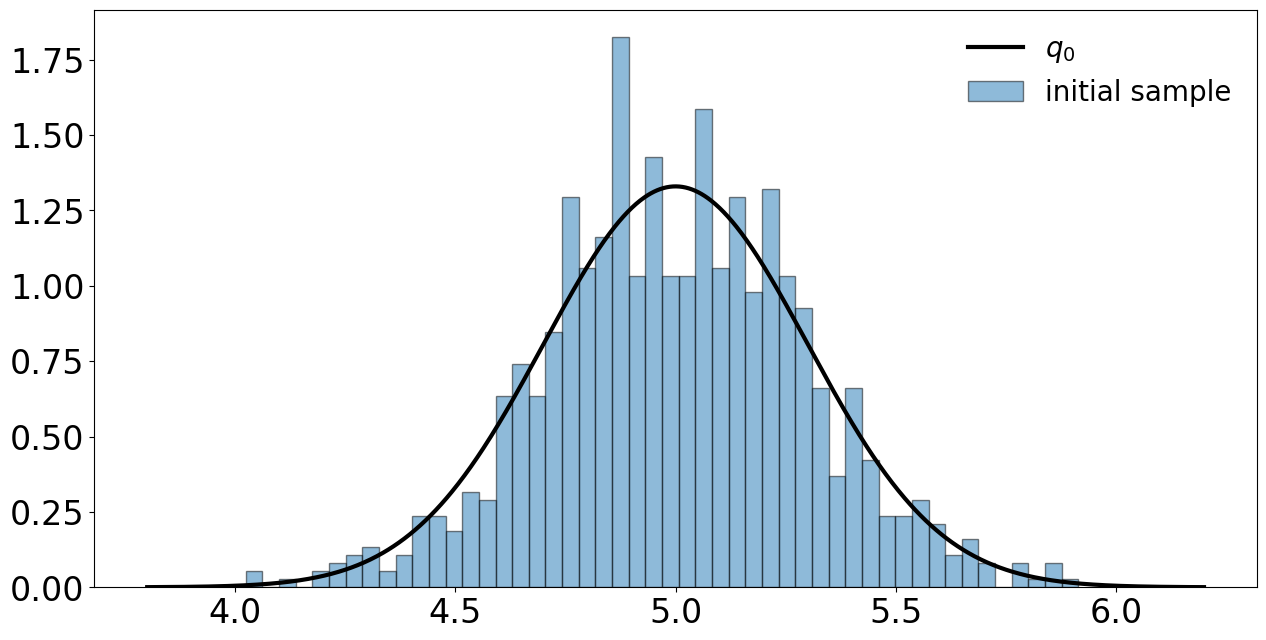

In [45]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(x[0,:],alpha=0.5,density=True,bins=50,ec='black',label='initial sample');
plt.legend(fontsize='small',frameon=False)

In [46]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='fwd')

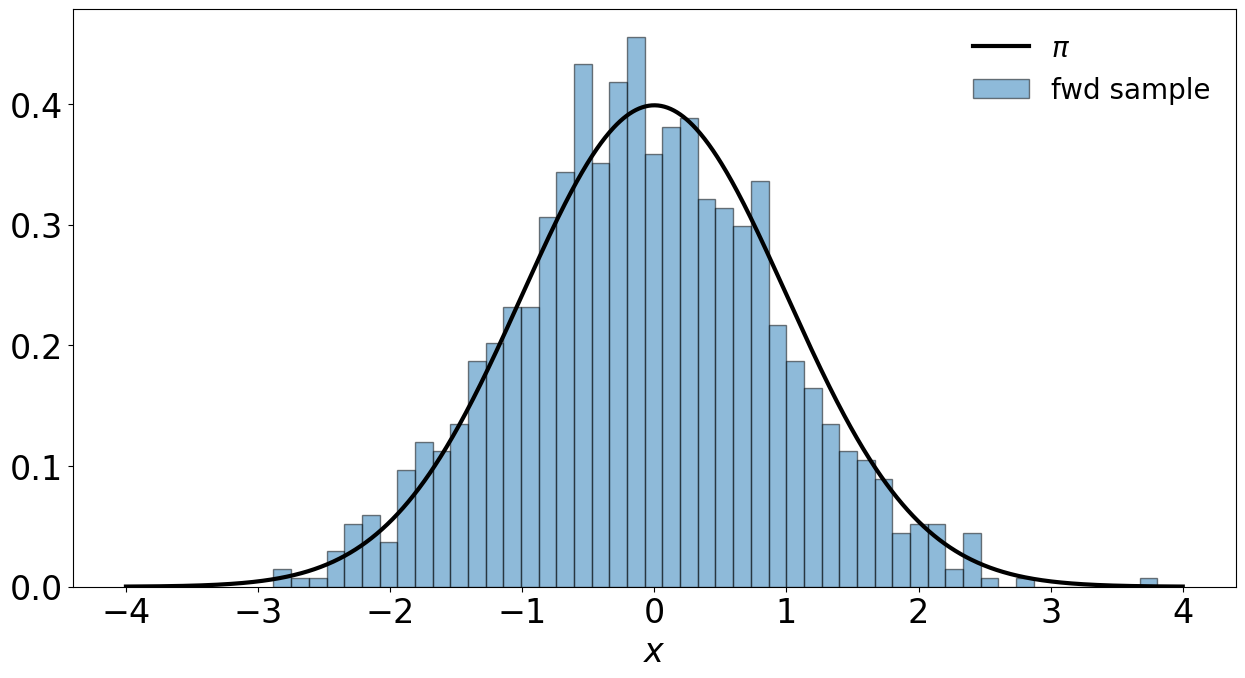

In [47]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

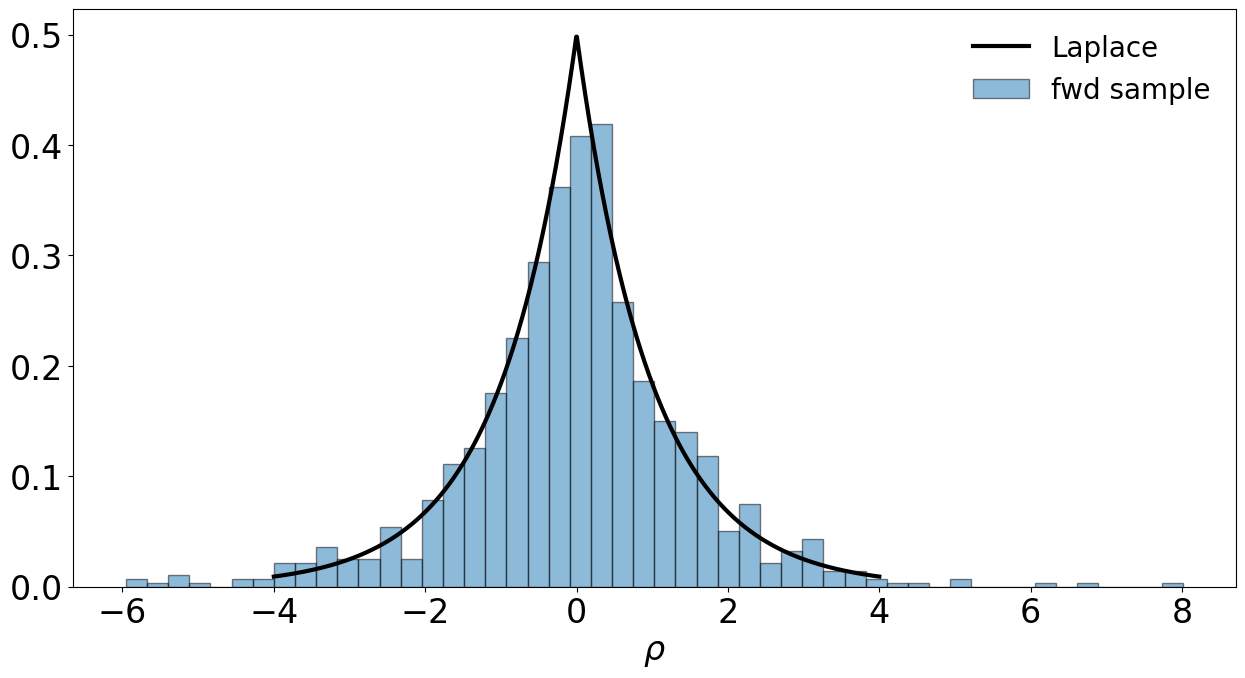

In [48]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small',frameon=False)

Text(0.5, 0, '$u$')

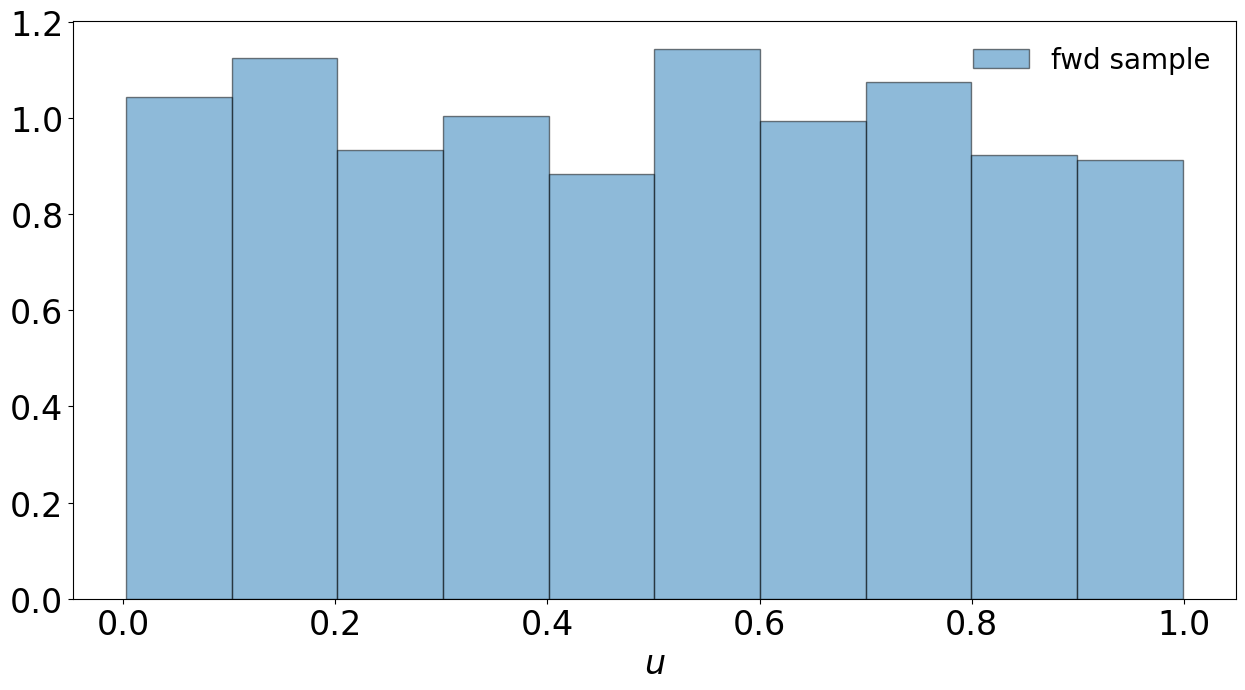

In [49]:
plt.hist(up,alpha=0.5,density=True,bins=10,ec='black',label='fwd sample');
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$u$')

## Backward pass

In [50]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

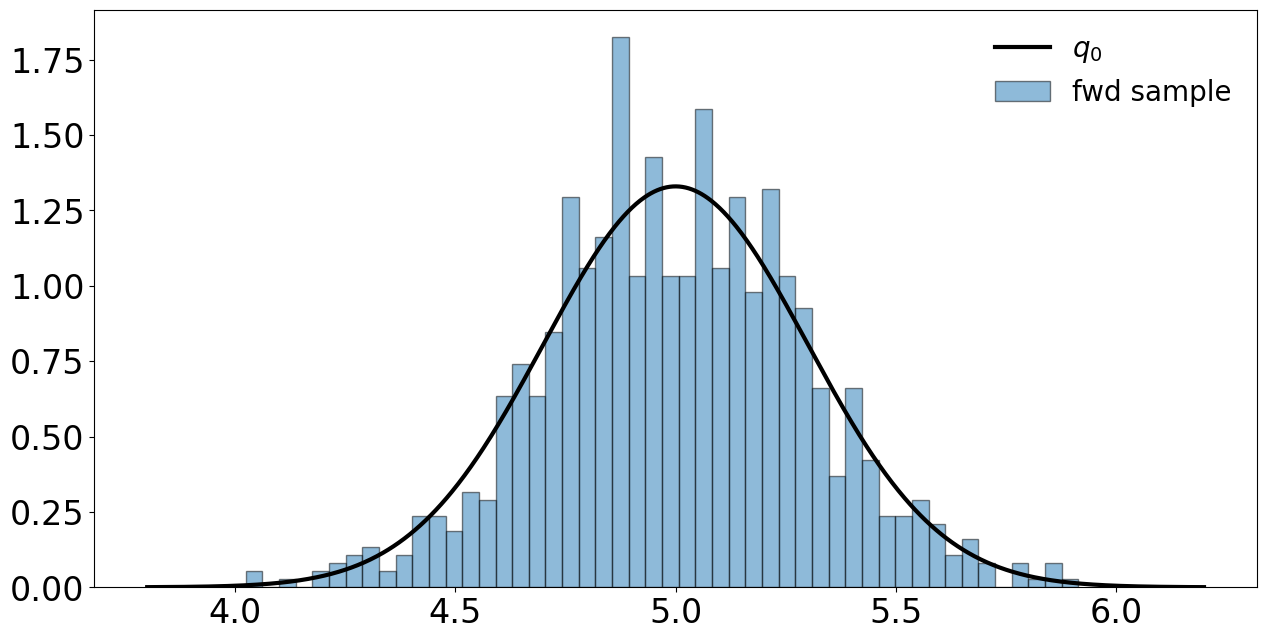

In [51]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='fwd sample');
plt.legend(fontsize='small',frameon=False)

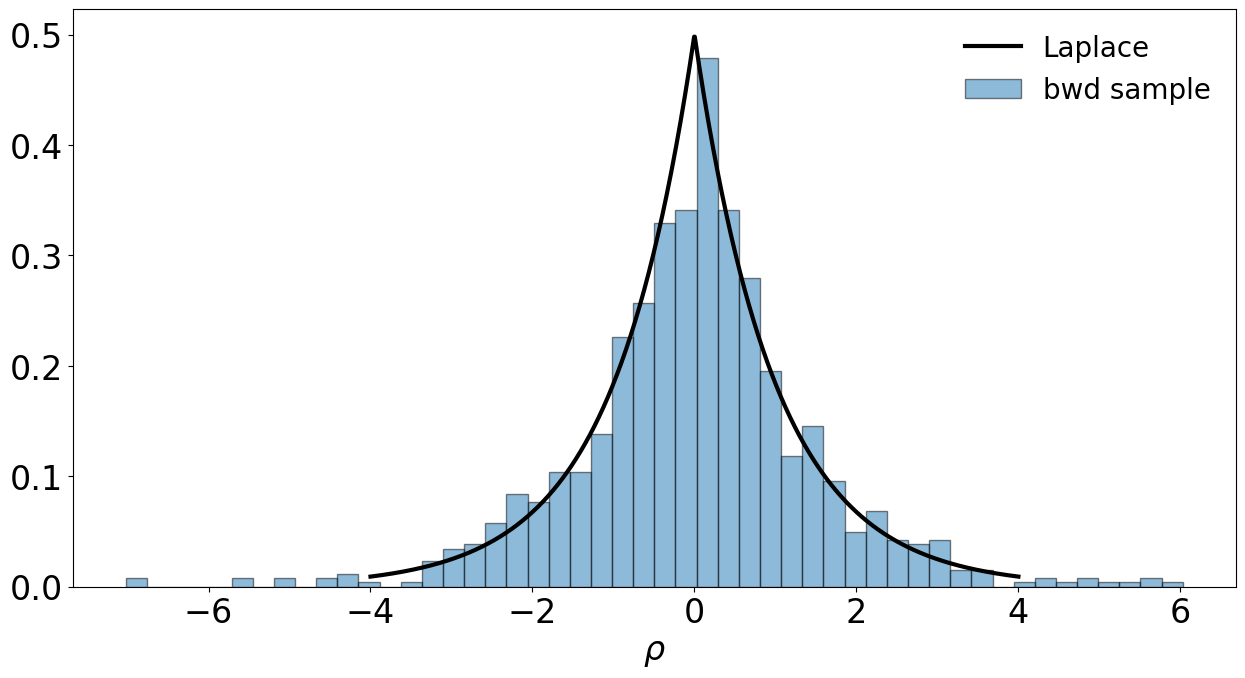

In [52]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])),c='black',lw=3,label='Laplace')
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$\rho$')
plt.legend(fontsize='small',frameon=False)

Text(0.5, 0, '$u$')

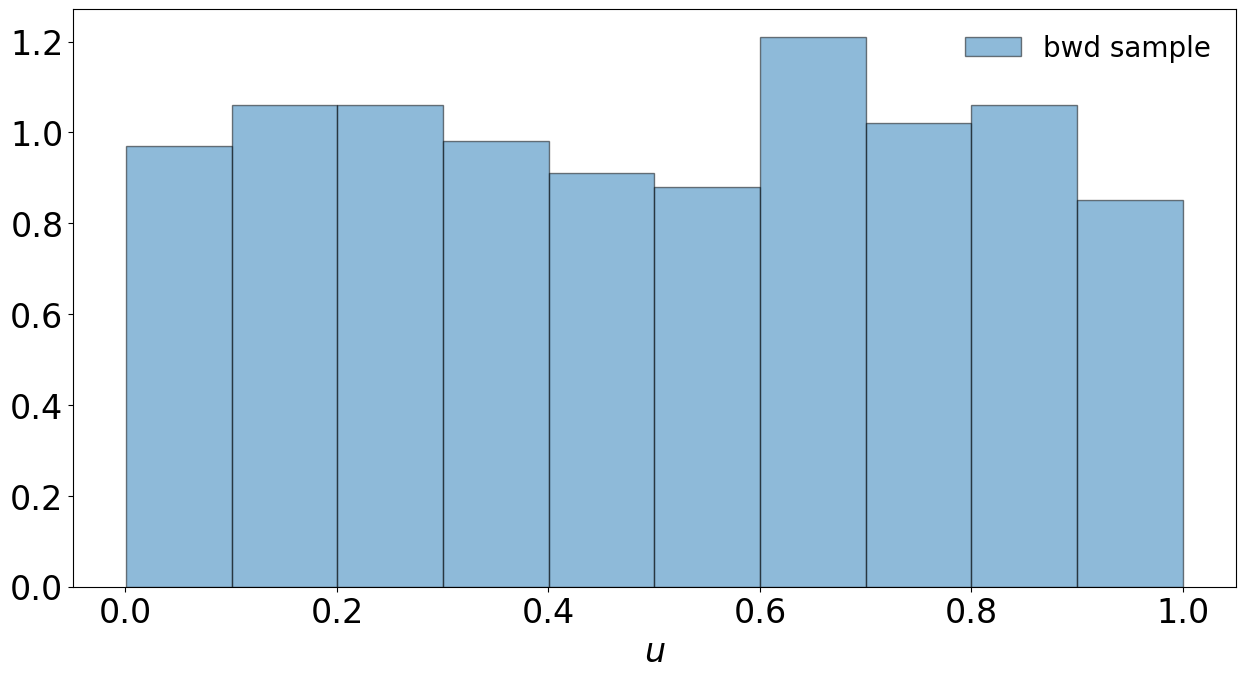

In [53]:
plt.hist(upp,alpha=0.5,density=True,bins=10,ec='black',label='bwd sample');
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$u$')

## Stability

Here we show a traceplot of the inverse flow with the (reversed) forward flow
to see if inversion is correct.

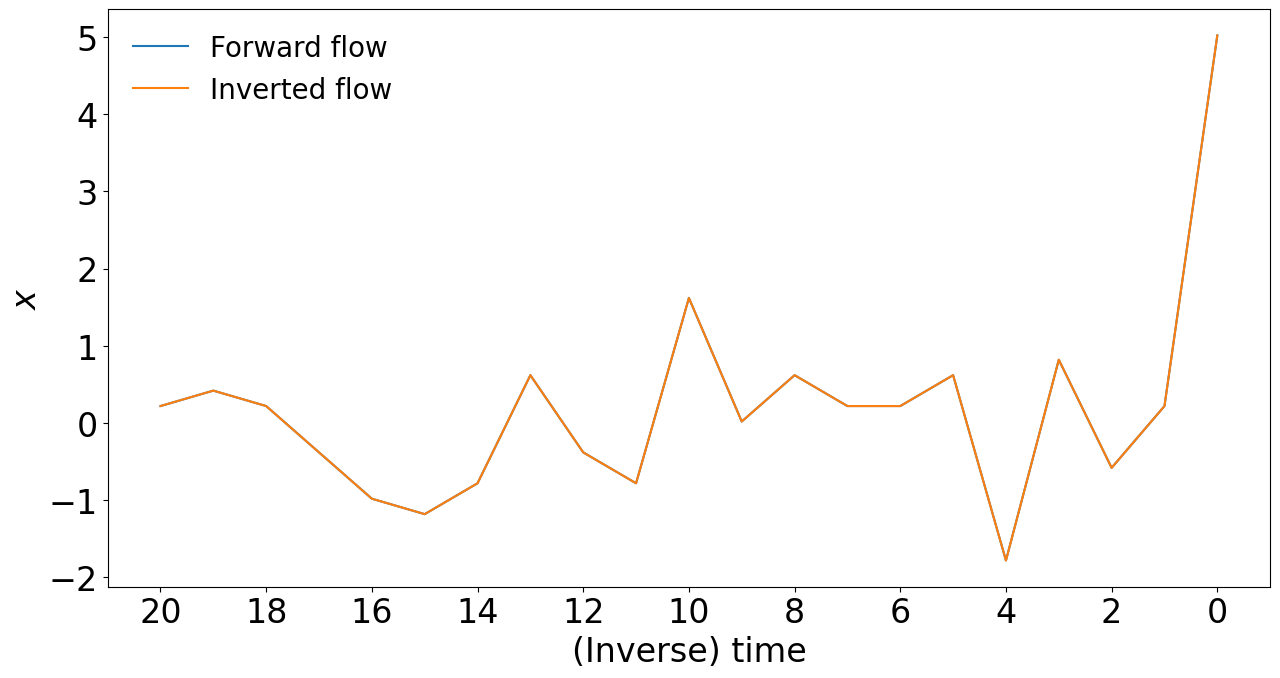

In [54]:
plt.plot(np.arange(0,steps+1),np.flip(xs[:,0,0]),label='Forward flow')
plt.plot(np.arange(0,steps+1),xps[:,0,0],label='Inverted flow')
plt.legend(fontsize='small',frameon=False)
plt.ylabel(r'$x$')
plt.xlabel('(Inverse) time')
plt.xticks(ticks=np.linspace(0,steps,11),
          labels=np.flip(np.linspace(0,steps,11,dtype=int)));

## Sampling

In [55]:
size=10000
sampling_steps=1000
xx,rrho,uu=randqN(size,sampling_steps,randq0,L,epsilon,grad_lp,xi)

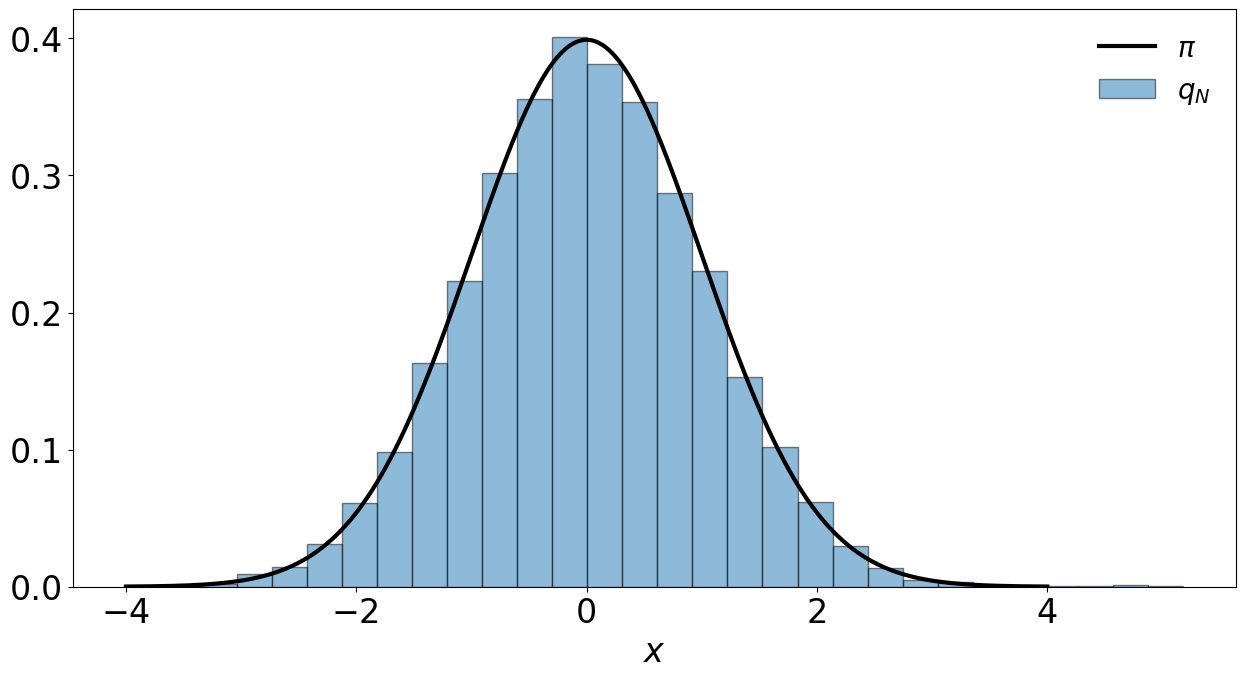

In [56]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(xx[0,:],bins=30,density=True,ec='black',alpha=0.5,label=r'$q_N$')
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

## Issue 1: inverting grids instead of pushed samples

In [57]:
new_steps=100
sample_size=1000
initial_x=np.linspace(-4,4,sample_size)[np.newaxis,:]
initial_rho=np.random.laplace(size=(1,sample_size))
initial_u=np.random.rand(sample_size)
L=50
epsilon=0.1

final_x,final_rho,final_u,lJs,all_xs,all_rhos,all_us=flow(new_steps,initial_x,initial_rho,initial_u,L,epsilon,
                                                          grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

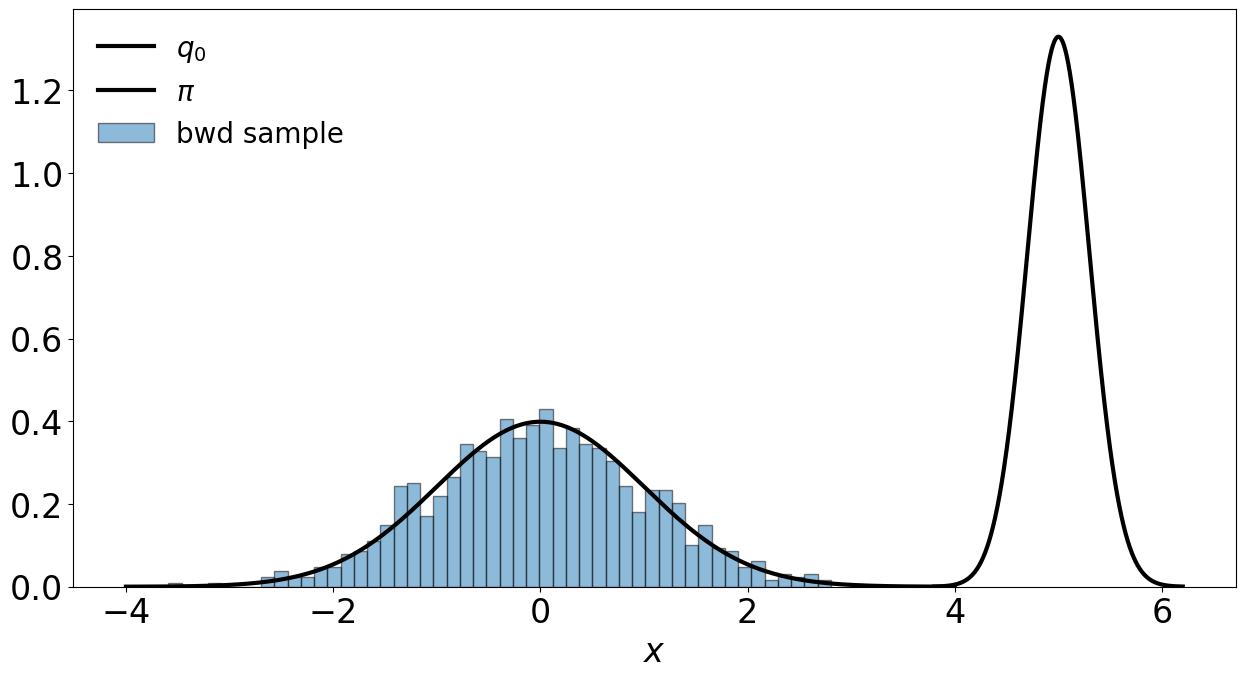

In [58]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)),c='black',lw=3,label=r'$q_0$')
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])),c='black',lw=3,label=r'$\pi$')
plt.hist(final_x[0,:],alpha=0.5,density=True,bins=50,ec='black',label='bwd sample');
plt.xlabel(r'$x$')
plt.legend(fontsize='small',frameon=False)

## Issue 2: density

In [62]:
lq,xs,rhos,us=lqN(xp,rhop,up,steps+1,lq0,L,epsilon,grad_lp,xi)

Flow: 1
x: 0.4202115138498037
rho: 0.04110856091757117
J: 0.9836211514186542
total J: 0.9836211514186542
Gaussian weight: 3.293931758127076e-51
Laplace weight: 0.47986246783627784
weight: 1.5547452537489797e-51
sum weights: 1.5547898857828572e-51

Flow: 2
x: 0.22021151384980367
rho: -0.09732439490279778
J: 1.0005096047350082
total J: 0.9841224094148714
Gaussian weight: 1.0028965040567606e-55
Laplace weight: 0.45363082366885366
weight: 4.551766091974065e-56
sum weights: 1.5548354034437768e-51

Flow: 3
x: -0.37978848615019634
rho: -0.014173224325589947
J: 0.9679690276203639
total J: 0.9526000117007226
Gaussian weight: 1.9668084204632193e-70
Laplace weight: 0.49296337148734354
weight: 9.385084159804818e-71
sum weights: 1.5548354034437768e-51

Flow: 4
x: -0.9797884861501963
rho: -0.48214990337402874
J: 2.688636662697107
total J: 2.5611953163442562
Gaussian weight: 7.064640600406799e-87
Laplace weight: 0.30872724815730496
weight: 5.864043066493821e-87
sum weights: 1.5548354034437768e-51

Fl

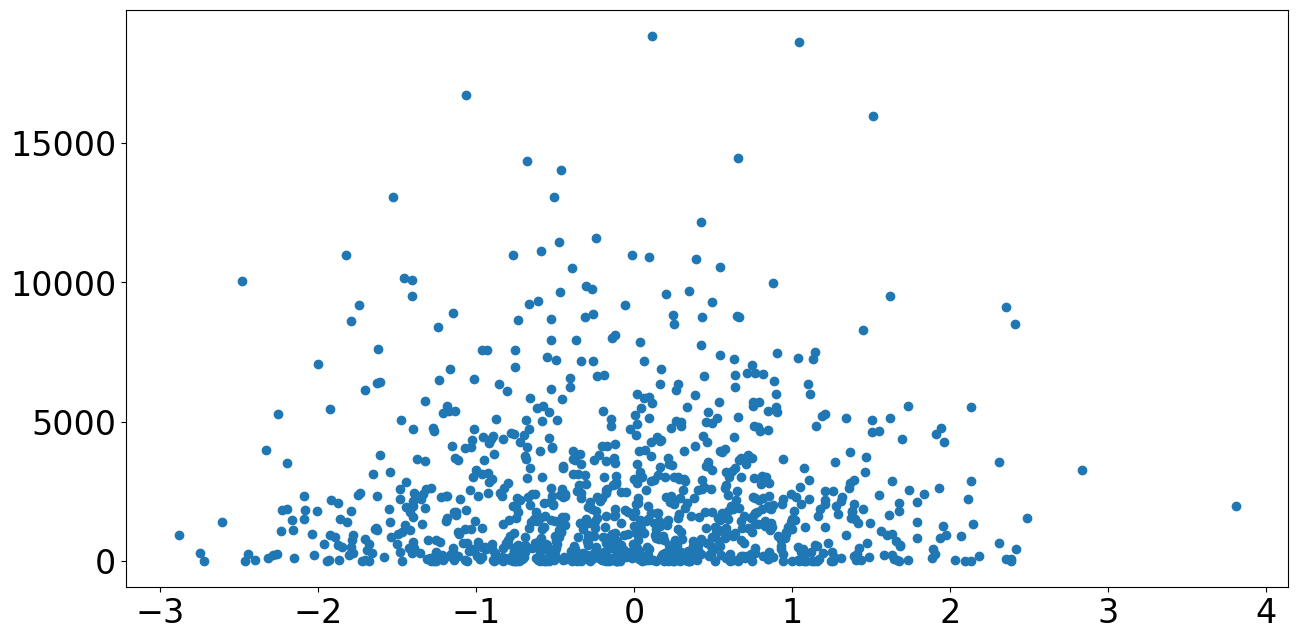

In [63]:
plt.scatter(xp,np.exp(lq))

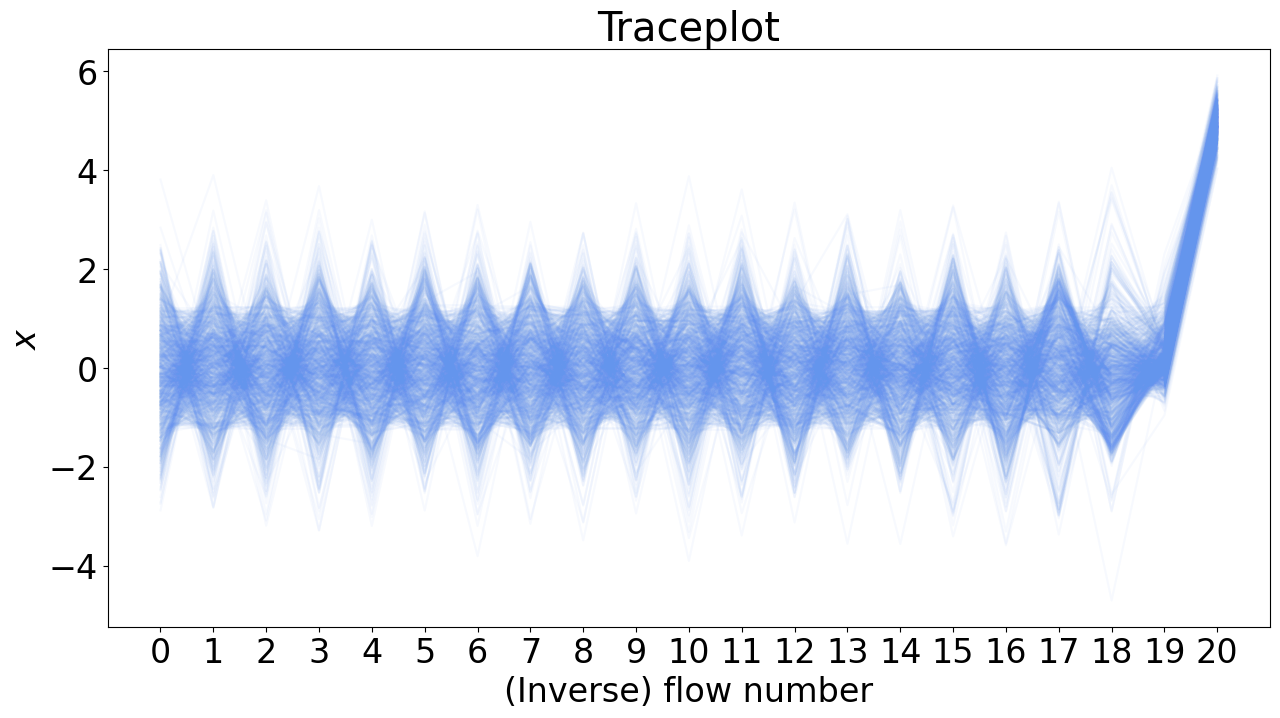

In [66]:
for n in range(xs.shape[-1]): plt.plot(np.arange(0,xs.shape[0]),xs[:,0,n],c='cornflowerblue',alpha=0.05)
plt.xlabel('(Inverse) flow number')
plt.ylabel(r'$x$')
plt.title('Traceplot')
plt.xticks(ticks=np.arange(0,steps+1));